In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
data = load_breast_cancer()
feature = data.data[:]
target = data.target[:]
target_labels = data.target_names

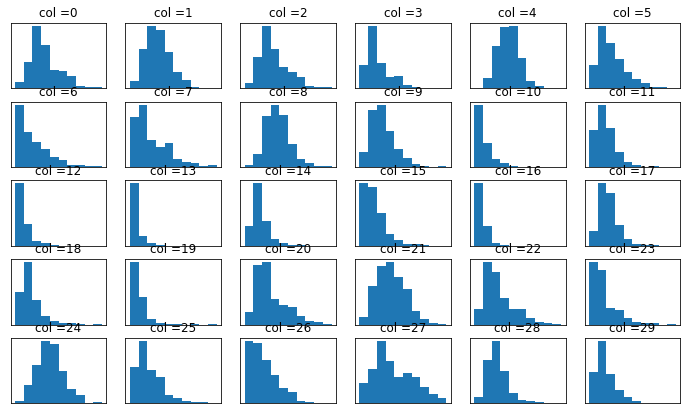

In [3]:
fig = plt.figure(figsize=(12, 7))

for idx in np.arange(30):
    ax = fig.add_subplot(5, 6, idx+1)
    ax.hist(feature[:, idx])
    plt.xticks([])
    plt.yticks([])
    plt.title('col =' + str(idx))

#### Adaptive binning:
Bin continuous numerical data for each column into quantiles and assign each row a catagoracal variable 

In [4]:
# place feature data into pandas dataframe
df = pd.DataFrame(data = feature)

First looking at a single feature column

In [5]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = df[0].quantile(quantile_list)
quantiles

0.00     6.981
0.25    11.700
0.50    13.370
0.75    15.780
1.00    28.110
Name: 0, dtype: float64

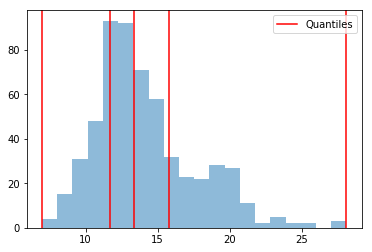

In [6]:
fig, ax = plt.subplots()
df[0].hist(bins=20, alpha=0.5, grid=False)

for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
    ax.legend([qvl], ['Quantiles'], fontsize=10)

In [7]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
df['{}_quantile_range'.format(str(0))] = pd.qcut(
                                            df[0], 
                                            q=quantile_list)
df['{}_quantile_label'.format(str(0))] = pd.qcut(
                                            df[0], 
                                            q=quantile_list,       
                                            labels=quantile_labels)

df[[0, '{}_quantile_range'.format(str(0)), 
               '{}_quantile_label'.format(str(0))]].sample(5)

,0,0_quantile_range,0_quantile_label
297,11.760,"(11.7, 13.37]",25-50Q
554,12.880,"(11.7, 13.37]",25-50Q
553,9.333,"(6.9799999999999995, 11.7]",0-25Q
8,13.000,"(11.7, 13.37]",25-50Q
337,18.770,"(15.78, 28.11]",75-100Q


Generate {column #}_quantile_range and {column #}_quantile_label for each feature column
Write to a new dataframe with only quantile labels for downstream use

In [8]:
quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']


df1 = pd.DataFrame()
for i in np.arange(0, 30):
    df['{}_quantile_range'.format(str(i))] = pd.qcut(
                                                df[i], 
                                                q=quantile_list)
    df['{}_quantile_label'.format(str(i))] = pd.qcut(
                                                df[i], 
                                                q=quantile_list,       
                                                labels=quantile_labels)
    df1['{}_quantile_label'.format(str(i))] = df['{}_quantile_label'.format(str(i))]
df1.head()

,0_quantile_label,1_quantile_label,2_quantile_label,3_quantile_label,4_quantile_label,5_quantile_label,6_quantile_label,7_quantile_label,8_quantile_label,9_quantile_label,...,20_quantile_label,21_quantile_label,22_quantile_label,23_quantile_label,24_quantile_label,25_quantile_label,26_quantile_label,27_quantile_label,28_quantile_label,29_quantile_label
0,75-100Q,0-25Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,...,75-100Q,0-25Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q
1,75-100Q,25-50Q,75-100Q,75-100Q,0-25Q,25-50Q,50-75Q,50-75Q,50-75Q,0-25Q,...,75-100Q,25-50Q,75-100Q,75-100Q,25-50Q,25-50Q,50-75Q,75-100Q,25-50Q,50-75Q
2,75-100Q,50-75Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,25-50Q,...,75-100Q,50-75Q,75-100Q,75-100Q,50-75Q,75-100Q,75-100Q,75-100Q,75-100Q,50-75Q
3,0-25Q,50-75Q,25-50Q,0-25Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,...,25-50Q,50-75Q,50-75Q,25-50Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q,75-100Q
4,75-100Q,0-25Q,75-100Q,75-100Q,50-75Q,75-100Q,75-100Q,75-100Q,50-75Q,25-50Q,...,75-100Q,0-25Q,75-100Q,75-100Q,50-75Q,25-50Q,75-100Q,75-100Q,0-25Q,25-50Q


In [9]:
#drop reference columns that contained quantile range just because
cols = [c for c in df.columns if 'range' in str(c)]
df = df.drop(labels=cols, axis='columns')

Create new dataframe that contains dummy variables for each column (one-hot-encoding for quantile catagorical values) 

In [14]:
df_ohe = pd.DataFrame()

for i in np.arange(0, 30):
    le = LabelEncoder()
    labels = le.fit_transform(df1['{}_quantile_label'.format(i)])
    mappings = {index: label for index, label in 
                      enumerate(le.classes_)}
    df1['{}_labels'.format(i)] = labels
    
    # reference only #_labels columns from original dataframe (df) to perform one_hot_encoding
    ohe = OneHotEncoder()
    feature_arr = ohe.fit_transform(
                                  df1[['{}_labels'.format(i)]]).toarray()
    feature_labels = list(le.classes_ + '_{}'.format(str(i)))
    features = pd.DataFrame(feature_arr, 
                            columns=feature_labels)
    df_ohe = pd.concat([df_ohe, features], axis = 1)


In [17]:
df_ohe.sample(10)

,0-25Q_0,25-50Q_0,50-75Q_0,75-100Q_0,0-25Q_1,25-50Q_1,50-75Q_1,75-100Q_1,0-25Q_2,25-50Q_2,...,50-75Q_27,75-100Q_27,0-25Q_28,25-50Q_28,50-75Q_28,75-100Q_28,0-25Q_29,25-50Q_29,50-75Q_29,75-100Q_29
33,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
130,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
554,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
320,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
22,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
95,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
328,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
360,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
218,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
488,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
